## Example Notebook of using Bayesian Inference in MAPS to do model selection in PTMCMC
First let's import the necessary packages

In [1]:
# If you are just testing this package without installing, you can add the package to the path
import sys
sys.path.insert(0,'../..')
import maps
print('Using maps from', maps.__file__)

Using maps from /Users/kushagran.nag/IPTA_GWB/anisotropy/MAPS/MAPS/docs/Bayesian_inference/../../maps/__init__.py


In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from maps import anis_pta as ap
from maps import utils

import numpy.random as rn
from enterprise.signals import anis_coefficients as ac
import pickle, corner
from la_forge import core, diagnostics

Optional mpi4py package is not installed.  MPI support is not available.


/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


## Simulate data

In MAPS, we consider amplitude scaled pulsar pairs cross-correlations ($\rho$) as our data. This can be modelled by the detector Overlap Reduction Function (ORF) given as $\Gamma = A (R \cdot P)$. Where, $A$ is the amplitude correction parameter.

In this example, to simulate $\Gamma$, first we define 67 pulsars uniformly distributed accross the sky, $nside$ defining the no. of pixel tessellation of the healpix sky (and hence no. of pixels in the sky), $l_{max}$ defining the maximum angular resolution of the sky to use for spherical harmonics representation. 

Here, for anisotropic model we use $l_{max}=6$ and for isotropic we must have $l_{max}=0$.

In [4]:
### Create a random draw generator with a seed
rng = rn.default_rng(seed=316)

In [5]:
npsrs = 67
nside = 8
l_max_anis = 6
l_max_iso = 0
nblm = int((l_max_anis/2+1)**2)

ncc = int(npsrs*(npsrs-1)/2)

print(f"Using {npsrs} pulsars with {ncc} pairs.")

Using 67 pulsars with 2211 pairs.


In [6]:
#Draw random uniform positions for pulsars in PTA
psrs_phi = rng.uniform(low = 0, high = 2 * np.pi, size = npsrs)
psrs_theta = np.arccos(1 - 2 * rng.uniform(0, 1, size = npsrs))

Now, initiate a PTA object without correlation values to gain access to some useful functions. Note that we can set data afterwards. Here, we define the basis in which we search for anisotropy. 

In this example, we will instantiate 2 PTA objects. One using 'sqrt_power_basis' which is the square-root spherical harmonics basis with $l_{max}=6$. Second using 'sqrt_power_basis' using $l_{max}=0$ (isotropic model).

In [7]:
pta_anis = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = l_max_anis, mode = 'sqrt_power_basis')
pta_iso = ap.anis_pta(psrs_theta, psrs_phi, nside = nside, l_max = l_max_iso, mode = 'sqrt_power_basis')

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


Some of the important functions that this sets up are: the response matrix $R$ of shape ($N_{cross-correlations} \times N_{pix}$), real-valued spherical harmonics $Y_{lm}(\theta, \phi)$ of shape ($N_{clm} \times N_{pix}$) and hence $\Gamma_{lm} = Y_{lm} \cdot R^{T}$ of shape ($N_{clm} \times N_{cross-correlations}$).

### Inject anisotropy

In this example, we can create injections using the method described below. However, other methods can also be used. Check other example notebooks for that.

* Adding a hotspot to an isotropic background: 
       We generate this as individual pixel powers. For an isotropic background, we can supply a pixel vector of all 1, meaning even power throughout the sky. On top of this, select a circular area on the sky at ($\theta$, $\phi$) for which we increase the power. We then combine this simulated map of shape ($N_{pix}$) with $R$ to create the injected data. 

Note that while MAPS does support pair covariance, this example will not use it.

We use a handy function in utils: ``` utils.inject_anisotropy(pta, method, **arg) ```. Here, all **arg are optional. This function creates the <span style="color:blue">injection</span> attributes of anis_pta instance/object. <span style="color:blue">pta.injected_rho</span>, <span style="color:blue">pta.injected_sig</span>, and <span style="color:blue">pta.injected_pair_cov</span> contains the injected cross_correlations ($\rho$) data, $1-d$ uncertainties on $\rho$, and diagonal pair-covariance matrix (None if not supplied) respectively. We also have <span style="color:blue">pta.injected_power</span>, and <span style="color:blue">pta.injected_Cl</span> which contains an array of injected pixel power, and angular power spectrum respectively which is very handy for post processing.

In [8]:
### One can add random noise using add_rand_noise=True 
### which adds gaussian noise scaled by sim_sig

### Here, we use a higher cross-correlation uncertainty.
utils.inject_anisotropy(pta_anis, method='pixel', sim_log10_A2=0.0, sim_power=40, sim_theta=np.pi/3, sim_phi=np.pi/2, lonlat=False, 
                        sim_pixel_radius=10, sim_sig=0.5, pair_cov=False, return_vals=False, add_rand_noise=False)

utils.inject_anisotropy(pta_iso, method='pixel', sim_log10_A2=0.0, sim_power=40, sim_theta=np.pi/3, sim_phi=np.pi/2, lonlat=False, 
                        sim_pixel_radius=10, sim_sig=0.5, pair_cov=False, return_vals=False, add_rand_noise=False)

Let's look at the injection in the skymap and ORF representation.

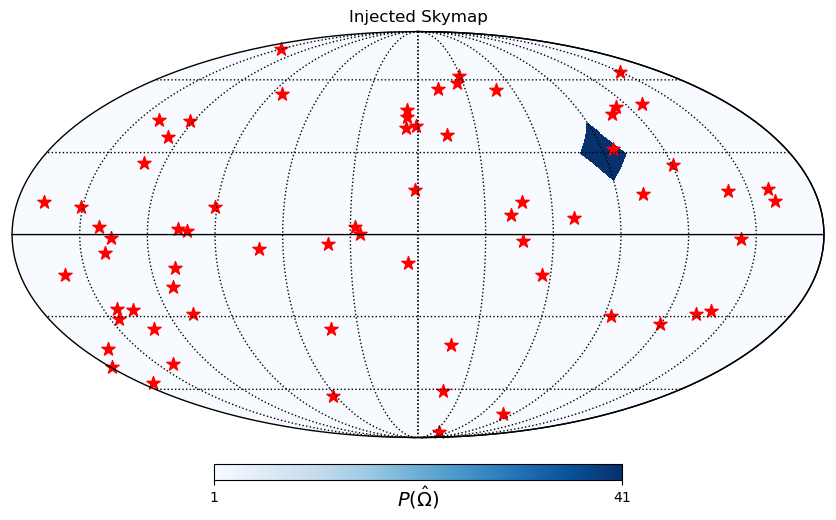

In [9]:
# Plot the injection
hp.mollview(pta_anis.injected_power,title = 'Injected Skymap',cmap='Blues', 
            unit='$P(\hat\Omega)$', rot=180)
hp.graticule()
hp.projscatter(pta_anis.psrs_theta, pta_anis.psrs_phi, color = 'red', marker = '*', s = 100)
plt.show()

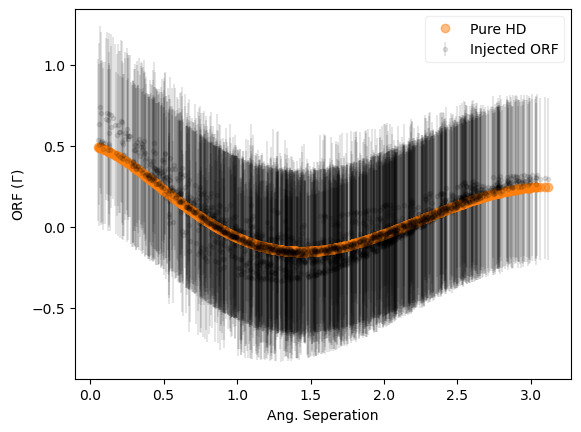

In [10]:
plt.errorbar(pta_anis.xi, pta_anis.injected_rho, pta_anis.injected_sig, marker='.', color='black', alpha=0.1, ls='', label='Injected ORF')
plt.plot(pta_anis.xi, pta_anis.get_pure_HD(), color='tab:orange', alpha=0.5, marker='o', ls='', label='Pure HD')

plt.xlabel('Ang. Seperation')
plt.ylabel(r'ORF ($\Gamma$)')

plt.legend(framealpha=0.3)
plt.show()

## Now let's run our bayesian inference

* First we supply both of our anis_pta object, the cross-correlation and uncertainty data we generated.

* Then we create a dictionary with these 2 models. We can assign name of these pta models as keys of the dictionary.

In [11]:
### Note that here pta.injected_pair_cov is None as we didn't supply it while creating the data
pta_anis.set_data(rho=pta_anis.injected_rho, sig=pta_anis.injected_sig, os=1, covariance=pta_anis.injected_pair_cov)
pta_iso.set_data(rho=pta_iso.injected_rho, sig=pta_iso.injected_sig, os=1, covariance=pta_iso.injected_pair_cov)

In [12]:
pta_models = {'sqrt_basis_6lmax':pta_anis, 'isotropy':pta_iso}

### Using PTMCMC custom Hypermodel sampler

* First, set an output directory for ptmcmc.

* Then create the ```anis_hypermodel(models, log_weights)``` instance by supplying it our models dictionary and log_weights (to ensure proper-mixing).

* Finally, setup the ptmcmc hypermodel sampler using the ```set_ptmcmc_hypermodel``` function of the anis_hypermodel instance.

* Note that uniform pirors for our parameters of both models are set internally here where one can pass the min and max prior boundaries. One can access the unique hypermodel priors with <span style="color:blue">priors</span> attribute of anis_hypermodel object. Whereas, the priors of individual pta's can be accessed with <span style="color:blue">priors</span> attribute of individual anis_pta object. Also, note that we can pickle the anis_hypermodel object to the outdir for better post-processing.

* To get an overview of models in hypermodel, on can access 'models_init' attribute of the anis_hypermodel object.

In [13]:
### set an output directory for ptmcmc
ptmcmc_outdir = './bayes_data/hypermodel/ptmcmc/'

In [14]:
### Instantiate the anis_hypermodel object
hypermodel_pta = ap.anis_hypermodel(models=pta_models, log_weights=[0, np.log(100)])

In [15]:
### Setup the ptmcmc sampler.
hypermodel_ptmcmc_sampler = hypermodel_pta.set_ptmcmc_hypermodel(log10_A2_prior_min=-2, log10_A2_prior_max=2, 
                                                                  bl0_prior_min=-5, bl0_prior_max=5, 
                                                                  blm_amp_prior_min=0, blm_amp_prior_max=5, 
                                                                  blm_phase_prior_min=0, blm_phase_prior_max=6.283185307179586, 
                                                                  outdir=ptmcmc_outdir, resume=True, save_anis_pta_hypermodel=True)

Adding nmodel uniform distribution draws...



In [ ]:
### To get an overview of models in hypermodel
#hypermodel_pta.models_init

In [16]:
### sampler for N steps
N = int(2e6)
### Get initial samples. this includes sample for nmodel parameter
x0 = hypermodel_pta.initial_sample()

In [17]:
### let's sample
hypermodel_ptmcmc_sampler.sample(x0, N, SCAMweight=25, AMweight=10, DEweight=40)

Finished 0.00 percent (0.00 percent of new work) in 0.003224 s Acceptance rate = 0

/Users/kushagran.nag/miniconda3/envs/GWB_IPTA/lib/python3.10/site-packages/enterprise/signals/parameter.py:70: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 0.50 percent (0.50 percent of new work) in 7.931815 s Acceptance rate = 0.472325Adding DE jump with weight 40
Finished 100.00 percent (100.00 percent of new work) in 799.061987 s Acceptance rate = 0.440067
Run Complete


## Post-processing

#### 1. First load the data

In [18]:
### For ptmcmc run
ptmcmc_core = core.Core(chaindir=ptmcmc_outdir, burn=0.25)

### If one wants to load the pickled anis_pta object
### with open(ptmcmc_outdir+'anis_pta_hypermodel.pickle', 'rb') as f:
###    hypermodel_pta = pickle.load(f)

#### 2. Let's look at the trace-plot

Here we mainly check if there is a proper mixing of the nmodel parameter. i.e. the switching between 2 models were frequent. One can also use diagnostic package to look at trace plots.

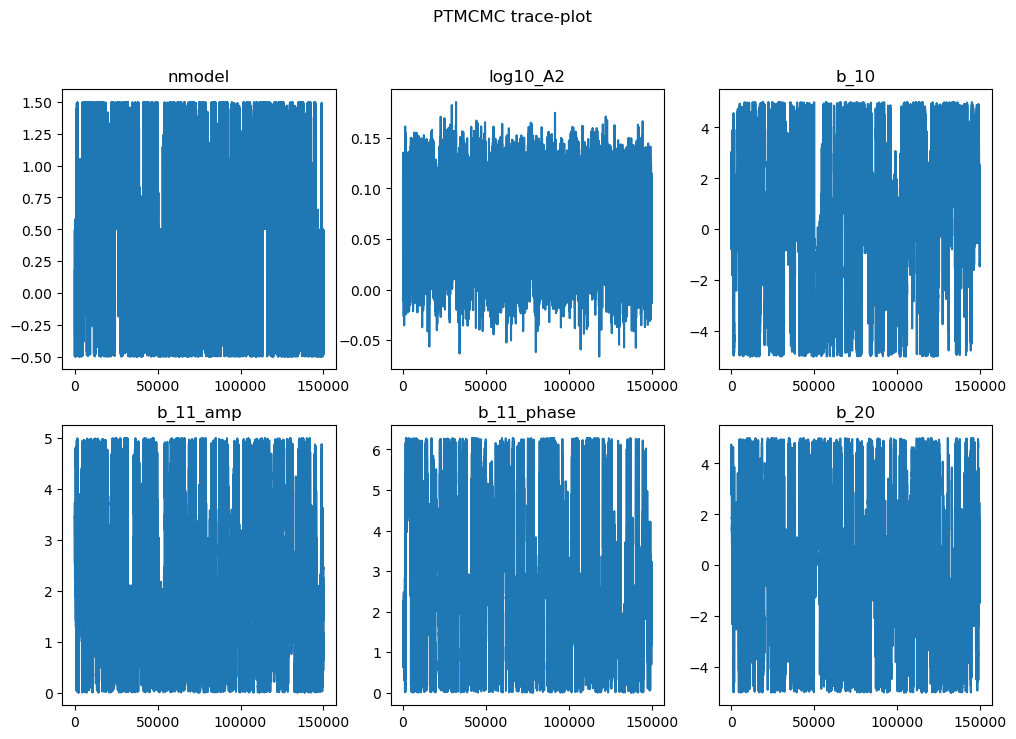

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(12,8))

fig.suptitle(r'PTMCMC trace-plot')

cnt = 0
for i in range(2):
    for j in range(3):
        ax[i][j].plot(ptmcmc_core.get_param(hypermodel_pta.param_names[cnt]), color='tab:blue')
        ax[i][j].set_title(hypermodel_pta.param_names[cnt])
        cnt += 1

plt.show()

#### 3. Bayes Factor

Now that there is a proper mixing of nmodel parameter, we can look at the the BF distribution. Here, BF is the re-weighted fraction of number of nmodel samples in model 2 to model 1.

* We use a handy function ```get_BF_dist_hypermodel(pta_anis_hypermodel, core, burn, realizations, seed)``` in utils to get the BF distribution. We supply the function with anis_hypermodel object, the chain core, burn-in samples (if not used while instantiating the core), number of realizations for bootstrapping and seed for random draws of posterior samples during bootstrapping.

* The above function first generates bootsrapped samples of nmodel parameter (using function ```bootstrap_1d(core, param, burn=0, realizations=1000, seed=316)``` in utils). Then it calculates BF for each realization using the weights, if provided, assigned to the models (making sure we exponentiate the log_weights). This function returns a dictionary whose key mentions BF of which model/which model (using the keys when we created the dictionary of pta's) and the values being the distribution. Here, the key will be 'isotropy/sqrt_basis_6lmax' (just one).

In [25]:
bf_dist_avi = utils.get_BF_dist_hypermodel(hypermodel_pta, ptmcmc_core, burn=0, realizations=5000)

Calc. BF dist.: 100%|█████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:37<00:00, 134.50it/s]


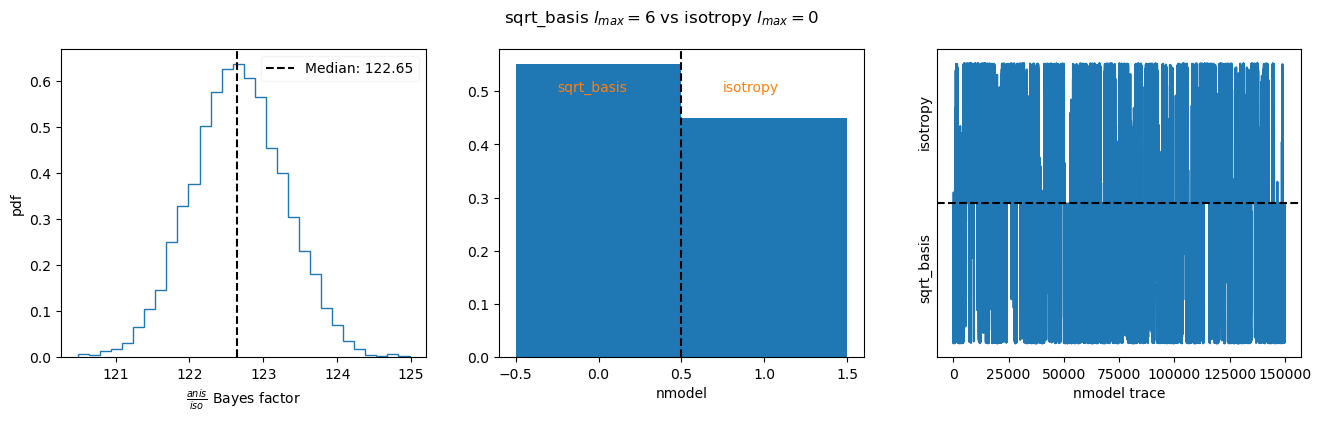

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

fig.suptitle(r'sqrt_basis $l_{max}=6$ vs isotropy $l_{max}=0$')

ax[2].plot(ptmcmc_core.get_param('nmodel'))
ax[2].axhline(0.5, color='k', ls='--')
ax[2].set_xlabel('nmodel trace')
ax[2].set_yticks([-0.5, 0.25, 0.5, 1.0, 1.25, 1.5])
ax[2].set_yticklabels(['', 'sqrt_basis', '', '', 'isotropy', ''])
ax[2].tick_params(axis='y', labelrotation=90, length=0)

ax[1].hist(ptmcmc_core.get_param('nmodel'), bins=2, density=True)
ax[1].axvline(0.5, color='k', ls='--')
ax[1].text(-0.25, 0.5, 'sqrt_basis', color='tab:orange')
ax[1].text(0.75, 0.5, 'isotropy', color='tab:orange')
ax[1].set_xlabel('nmodel')

ax[0].hist(1/bf_dist_avi['isotropy/sqrt_basis_6lmax'], bins=30, histtype='step', density=True)
ax[0].axvline(np.median(1/bf_dist_avi['isotropy/sqrt_basis_6lmax']), ls='--', color='black', 
              label=r'Median: %.2f' %np.median(1/bf_dist_avi['isotropy/sqrt_basis_6lmax']))
ax[0].set_xlabel(r'$\frac{anis}{iso}$ Bayes factor')
ax[0].set_ylabel('pdf')
ax[0].legend(framealpha=0.2)

plt.show()

##### Here we see that the anisotropic model is strongly favoured (median BF = $122.65$). That's what we injected with moderate SNR!